## Import Libraries and Camera Calibration

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import cv2 
import pickle
import glob
#from scipy.misc import imread, imresize
from skimage.transform import resize
from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

file_name = 'Camera_Calibration/fisheye_360x640_calibration.p'

with open(file_name, 'rb') as f:   
    mtx, dist = pickle.load(f) # load camera matrix and list of distortion coefficients

#new_mtx = cv2.getOptimalNewCameraMatrix(mtx, dist, (360,640), 0.8)[0]
new_mtx = mtx.copy()
new_mtx[0,0]=mtx[0,0]/0.85
new_mtx[1,1]=mtx[1,1]/0.85
# Just by scaling the matrix coefficients!
print('mtx: ',mtx)
print('new_mtx: ',new_mtx)
print('done')

mtx:  [[ 254.64261205    0.          317.52625459]
 [   0.          255.73738278  165.03395646]
 [   0.            0.            1.        ]]
new_mtx:  [[ 299.57954359    0.          317.52625459]
 [   0.          300.86750915  165.03395646]
 [   0.            0.            1.        ]]
done


## Not part of lane line detection: Only run this code block if you want to extract frames from video 

In [ ]:
"""
This code block converts video to its individual frames. It only needs to be run once. Please only run this block
if you have a new video for which you'd like to extract its frames. 
"""

path = 'RC_Car_Images_And_Videos/Hershels_Garage/Fisheye/video6/video6.mp4'
vidcap = cv2.VideoCapture(path)
success,image = vidcap.read()

count = 0
success = True

while success:
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  cv2.imwrite('RC_Car_Images_And_Videos/Hershels_Garage/Fisheye/video6/frames/%d.jpg' % count, image)     # save frame as JPEG file
  count += 1

## Useful Functions

In [2]:
# Draws viewing window onto copy of image
def draw_viewing_window(image,viewing_window):
    image_copy = np.copy(image)
    for line in viewing_window:
        for x1,y1,x2,y2 in line:
            cv2.line(image_copy,(x1,y1),(x2,y2),(0,255,0),5)
    return image_copy

# Makes the viewwing window which is used by draw_viewing_window()
def make_viewing_window(bottom_left,top_left,top_right,bottom_right):
    left_line = np.array([[bottom_left[0],bottom_left[1],top_left[0],top_left[1]]])
    top_line = np.array([[top_left[0],top_left[1],top_right[0],top_right[1]]])
    right_line = np.array([[top_right[0],top_right[1],bottom_right[0],bottom_right[1]]])
    bottom_line = np.array([[bottom_right[0],bottom_right[1],bottom_left[0],bottom_left[1]]])
    viewing_window = [left_line,top_line,right_line,bottom_line]

    return viewing_window

# Applies sobel algorithm with respect to x or y axis with thresholded gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=7, thresh_min=0, thresh_max=255):
    
    
    # Convert to gray-scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take derivative
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_32F, 1, 0 ,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_32F, 0, 1,ksize=sobel_kernel)
    
    # Take absolute value of derivative    
    abs_sobel = np.absolute(sobel)
    
    # Convert to 8-bit image (0 - 255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Make copy of scaled_sobel with all zeros
    sobel_binary = np.zeros_like(scaled_sobel)
    # Make all pixels within threshold range a value of 1
    # Keep all other pixels as 0
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = sobel_binary
    # binary_output = np.copy(img) # Remove this line
    return binary_output

# Function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def sobel_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take derivatives in both x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_kernel)
    # Find magnitude of the gradient
    sum_of_squares = np.square(sobelx) + np.square(sobely)
    sobel_mag = np.power(sum_of_squares,0.5)
    # Convert to 8-bit image (0 - 255)
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # Make a copy of sobel_mag with all zeros
    sobel_binary = np.zeros_like(scaled_sobel)
    # Make all pixels within threshold range a value of 1
    # Keep all other pixels as 0
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    binary_output = sobel_binary

    return binary_output

# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
        
    # Min and Max Threshold Angles
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the derivatives with respect to x and y
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=sobel_kernel)
    # Take absolute value of derivatives
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Calculate angle for direction of gradient in radians
    sobel_angle = np.arctan2(abs_sobely,abs_sobelx)
    # Make a copy of sobel_angle with all zeros
    sobel_binary = np.zeros_like(sobel_angle)
    # Apply thresholding
    sobel_binary[(sobel_angle >= thresh_min) & (sobel_angle <= thresh_max)] = 1
    binary_output = sobel_binary
    
    return binary_output

def region_of_interest(gray,limit_look_ahead):
    height = gray.shape[0]
    m = np.copy(gray) + 1
    #m[:, :50] = 0 
    #m[:, 590:] = 0 
    #m[:,0:50] = 0
    m[:int(limit_look_ahead*height),:] = 0 # cutoff top part of image to limit look-ahead
    #m[440:480,200:400] = 0 # cutoff small rectangle at bottom of image to cover up the car

    return m 


# Takes in RGB image and applies color and gradient thresholding
def combined_threshold(image, kernel_size=3, gradx_low_thresh=40, gradx_high_thresh=100, 
                       grady_low_thresh=40, grady_high_thresh=100, mag_low_thresh=40,
                       mag_high_thresh=100, dir_low_thresh=0.7, dir_high_thresh=1.3,
                       white_L_low_thresh = 130, white_L_high_thresh = 244, white_S_low_thresh =13, 
                       white_S_high_thresh=50, yellow_S_low_thresh=140, yellow_S_high_thresh = 255,
                       yellow_H_low_thresh=20, yellow_H_high_thresh=30, L_agr=205):
    
    # Find White Lane Line Pixels
    
    # Convert image to HLS space
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Extract Just H channel
    H = image_hls[:,:,0]
    H_thresholded = np.zeros_like(H)
    thresh_H = (0,165)
    H_thresholded[(H >= thresh_H[0]) & (H <= thresh_H[1])] = 1
    
    # Extract just S channel
    S = image_hls[:,:,2]
    S_thresholded = np.zeros_like(S)
    # thresh_S = (140, 255)
    thresh_S = (white_S_low_thresh, white_S_high_thresh)
    S_thresholded[(S >= white_S_low_thresh) & (S <= white_S_high_thresh)] = 1
    
    # Extract just L channel
    L = image_hls[:,:,1]
    L_thresholded = np.zeros_like(L)
    thresh_L = (white_L_low_thresh, white_L_high_thresh)
    L_thresholded[(L >= white_L_low_thresh) & (L <= white_L_high_thresh)] = 1
    
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    A = image_lab[:,:,1]
    A_thresholded = np.zeros_like(A)
    thresh_A = (125,131)
    A_thresholded[(A >= thresh_A[0]) & (A <= thresh_A[1])] = 1
    
    B = image_lab[:,:,2]
    B_thresholded = np.zeros_like(B)
    thresh_B = (120,129)
    B_thresholded[( B >= thresh_B[0]) & (B <= thresh_B[1])] = 1
    
    LAB_L = image_lab[:,:,0]
    LAB_L_thresholded = np.zeros_like(LAB_L)
    LAB_L_thresholded[(LAB_L >=121) & (LAB_L <= 237)] = 1
    
    image_YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    Cr = image_YCrCb[:,:,1]
    Cr_thresholded = np.zeros_like(Cr)
    #thresh_Cr = (143,154)
    thresh_Cr = (124,127)
    Cr_thresholded[( Cr >= thresh_Cr[0]) & (Cr <= thresh_Cr[1])] =1
    
    Cb = image_YCrCb[:,:,2]
    Cb_thresholded = np.zeros_like(Cb)
    thresh_Cb = (128,136)
    #thresh_Cb = (0,255)
    Cb_thresholded[( Cb >= thresh_Cb[0] & (Cb <= thresh_Cb[1]))] = 1
    
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    Y = image_yuv[:,:,0]
    Y_thresholded = np.zeros_like(Y)
    thresh_Y = (132,255)
    #thresh_U = (0,255)
    Y_thresholded[((Y >= thresh_Y[0]) & (Y <= thresh_Y[1]))] = 1
    
    U = image_yuv[:,:,1]
    U_thresholded = np.zeros_like(U)
    thresh_U = (127,135)
    #thresh_U = (0,255)
    U_thresholded[((U >= thresh_U[0]) & (U <= thresh_U[1]))] = 1
    
    V = image_yuv[:,:,2]
    V_thresholded = np.zeros_like(V)
    thresh_V = (124,129)
    #thresh_V = (0,255)
    V_thresholded[((V >= thresh_V[0]) & (V <= thresh_V[1]))] = 1
    
    image_luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    
    LUV_U = image_luv[:,:,1]
    LUV_U_thresholded = np.zeros_like(LUV_U)
    LUV_U_thresholded[((LUV_U >= 94) & (LUV_U <= 97))] = 1
    
    LUV_V = image_luv[:,:,2]
    LUV_V_thresholded = np.zeros_like(LUV_V)
    LUV_V_thresholded[((LUV_V >= 124) & (LUV_V <= 138))] = 1
    
    image_hsv = cv2.cvtColor(image , cv2.COLOR_RGB2HSV)
    
    HSV_H = image_hsv[:,:,0]
    HSV_H_thresholded = np.zeros_like(HSV_H)
    HSV_H_thresholded[(HSV_H >= 75) & (HSV_H <= 120)] = 1
    
    HSV_S = image_hsv[:,:,1]
    HSV_S_thresholded = np.zeros_like(HSV_S)
    HSV_S_thresholded[(HSV_S >= 1) & (HSV_S <= 31)] = 1
    
    HSV_V = image_hsv[:,:,2]
    HSV_V_thresholded = np.zeros_like(HSV_V)
    HSV_V_thresholded[(HSV_V >= 124) & (HSV_V <= 255)] = 1
    
    white_thresholded = np.zeros_like(B)
    #white_thresholded[((Cr_thresholded == 1) & (L_thresholded == 1) & (H_thresholded == 1) & (S_thresholded == 1) & (V_thresholded == 1) \
    #                   & (U_thresholded == 1) & (LUV_V_thresholded == 1) & (LUV_U_thresholded == 1) & (Cb_thresholded == 1)
    #                  \ & (A_thresholded == 1) & (B_thresholded == 1) & (HSV_H_thresholded == 1) & (HSV_S_thresholded == 1) & \
    #                  (LAB_L_thresholded == 1))] = 1
    white_thresholded[((S_thresholded == 1) & (HSV_V_thresholded == 1) & (Y_thresholded == 1) \
                        & (V_thresholded == 1) & (B_thresholded == 1) & (LUV_U_thresholded == 1) \
                        & (LUV_V_thresholded == 1))] = 1
    
    # Find Yellow Lane Line Pixels
    
    # Extract just S channel
    S = image_hls[:,:,2]
    S_thresholded = np.zeros_like(S)
    # thresh_S = (140, 255)
    thresh_S = (yellow_S_low_thresh, yellow_S_high_thresh)
    S_thresholded[(S >= yellow_S_low_thresh) & (S <= yellow_S_high_thresh)] = 1
    
    # Extract just H channel
    
    H = image_hls[:,:,0]
    H_thresholded = np.zeros_like(H)
    thresh_H = (yellow_H_low_thresh, yellow_H_high_thresh)
    H_thresholded[(H >= yellow_H_low_thresh) & (H <= yellow_H_high_thresh)] = 1
    
    image_luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    
    LUV_U = image_luv[:,:,1]
    LUV_U_thresholded = np.zeros_like(LUV_U)
    LUV_U_thresholded[((LUV_U >= 91) & (LUV_U <= 96))] = 1
    
    LUV_V = image_luv[:,:,2]
    LUV_V_thresholded = np.zeros_like(LUV_V)
    LUV_V_thresholded[((LUV_V >= 160) & (LUV_V <= 160))] = 1
    
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    YUV_V = image_yuv[:,:,2]
    YUV_V_thresholded = np.zeros_like(YUV_V)
    YUV_V_thresholded[((YUV_V >= 125) & (YUV_V) <= 129)] = 1
    
    yellow_thresholded = np.zeros_like(H)
    yellow_thresholded[(H_thresholded == 1) & (S_thresholded == 1)] = 1
    
    # Keep very brigh pixels by looking at just L channel
    
    # Extract just L channel
    L = image_hls[:,:,1]
    #L_thresholded = np.zeros_like(L)
    #thresh_L = (L_low_thresh, L_high_thresh)
    #L_thresholded[(L >=thresh_L[0]) & (L <= thresh_L[1])] = 1
    thresh_L_agr = L_agr
    L_thresholded2 = np.zeros_like(L)
    L_thresholded2[L>=thresh_L_agr] = 1
    
    # Calculate gradients
    
    # gradx original: (40,255)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=kernel_size, thresh_min=gradx_low_thresh,
                             thresh_max=gradx_high_thresh)
    # I did not use grady in the final output
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=kernel_size, thresh_min=grady_low_thresh,
                             thresh_max=grady_high_thresh)
    # mag_binary original: (40,255)
    mag_binary = sobel_mag_thresh(image, sobel_kernel=kernel_size, mag_thresh=(mag_low_thresh,mag_high_thresh))
    dir_binary = dir_threshold(image,sobel_kernel=kernel_size,thresh=(dir_low_thresh,dir_high_thresh))

    
    # Combine all the thresholds
    
    combined = np.zeros_like(dir_binary)
      
    
    
    # Mithi's gradient and color thresholds
    #combined[((mag_binary == 1) & (dir_binary == 1) & (gradx == 1)) | \
    #          (((S_thresholded == 1) & (L_thresholded == 1)) | (L_thresholded2 == 1))] = 1
    
    # Adam's gradient and color thresholds
    combined[((mag_binary == 1) &  (gradx == 1) & (dir_binary == 1)) | \
              ( (white_thresholded == 1) | (yellow_thresholded == 1) | (L_thresholded2 == 1))] = 1

    #combined[((mag_binary == 1) & (dir_binary == 1) & (S_thresholded == 1) & (L_thresholded == 1))] = 1
    
    #combined = np.logical_and(combined,region_of_interest(combined)).astype(np.uint8)
    
    return combined

# image is an undistorted image
def apply_birdseye(image,source_points,dest_points):
    
    source_points = np.asarray(source_points)
    dest_points = np.asarray(dest_points)
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    img_size = (image.shape[1],image.shape[0])

    birds_eye_image = cv2.warpPerspective(image, M, img_size,
                                          flags=cv2.INTER_LINEAR)

    # Applying Combined Color and Gradient Thresholding to Birds Eye View Image
    #combined = combined_threshold(birds_eye_image,kernel_size=11)
    
    
    #return combined
    return birds_eye_image

print('done')
    

done


## Undistorting the Image

In [ ]:
video_number = 4 # can be 1-6

#image_paths = glob.glob('RC_Car_Images_And_Videos/Kemper/video4_test_images/*.jpg')
#image_paths = glob.glob('RC_Car_Images_And_Videos/Hershels_Garage/One_Light/full_track_test_images/*.jpg')
#image_paths = glob.glob('RC_Car_Images_And_Videos/Hershels_Garage/One_Light/partial_track2_test_images/*.jpg')
#image_paths = glob.glob('RC_Car_Images_And_Videos/Hershels_Garage/One_Light/full_track_test_images/*.jpg')
#image_paths = glob.glob('RC_Car_Images_And_Videos/Hershels_Garage/One_Light/Full_Track_Camera_Facing_Forward/video%d/test_images/*.jpg' % video_number)

image_paths = glob.glob('RC_Car_Images_And_Videos/Hershels_Garage/Fisheye/video%d/test_images/*.jpg' % video_number)

num_pictures = len(image_paths)
f, axs = plt.subplots(4,4, figsize=(10,15))
axs = axs.ravel()
print(len(axs))
#print(image_paths)
image = cv2.imread(image_paths[0])
image_undistorted = cv2.undistort(image,mtx,dist,None,mtx)

for i,img in enumerate(image_paths):
    #img = 'hershels_test_images/frame' + str(i) + '.jpg'
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print('image.shape: ',image.shape)
    #image_undistorted = cv2.undistort(image,mtx,dist,None,mtx)
    image_undistorted = cv2.undistort(image,mtx,dist,None,mtx)
    axs[i*2].imshow(image)
    axs[i*2].set_title('original')
    axs[i*2+1].imshow(image_undistorted)
    axs[i*2+1].set_title('undistorted')

## Converting to BirdsEye View

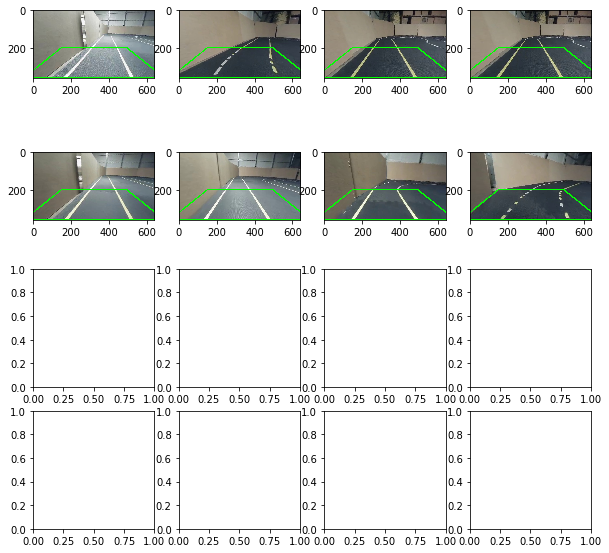

In [4]:

#mtx = new_mtx
# Defining my source points
"""
These source points work with image 'rc_test_images/00330002.jpg'
src_bottom_left = [-225,460]
src_top_left = [250,25]
src_top_right = [375,25]
src_bottom_right = [850,460]
"""
"""
src_bottom_left = [25,480]
src_top_left = [75,275]
src_top_right = [600,275]
src_bottom_right = [625,480]

# Source Points for original bad lighting videos
src_bottom_left = [-50,480]
src_top_left = [125,300]
src_top_right = [550,300]
src_bottom_right = [690,480]
source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                 src_bottom_right])

# source points for 480p using one light in hershel's garage
src_bottom_left = [-50,480]
src_top_left = [125,200]
src_top_right = [550,200]
src_bottom_right = [690,480]
source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                 src_bottom_right])
                 
# source points for 720p using one light in hershel's garage
src_bottom_left = [-50,720]
src_top_left = [300,450]
src_top_right = [980,450]
src_bottom_right = [1330,720]
source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                 src_bottom_right])
                 
"""
# source points for 360x640 using fisheye in hershel's garage
src_bottom_left = [-50,360]
src_top_left = [150,200]
src_top_right = [490,200]
src_bottom_right = [690,360]
source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                 src_bottom_right])


src_viewing_window = make_viewing_window(src_bottom_left,src_top_left,src_top_right,src_bottom_right)

f, axs = plt.subplots(4,4, figsize=(10,10))
axs = axs.ravel()
for i,img in enumerate(image_paths):
    #img = 'rc_test_images/lane' + str(i+1) + '.jpg'
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # don't forget to undistort image
    image = cv2.undistort(image,mtx,dist,None,mtx)
    image_copy = draw_viewing_window(image,src_viewing_window)
    axs[i].imshow(image_copy)
    


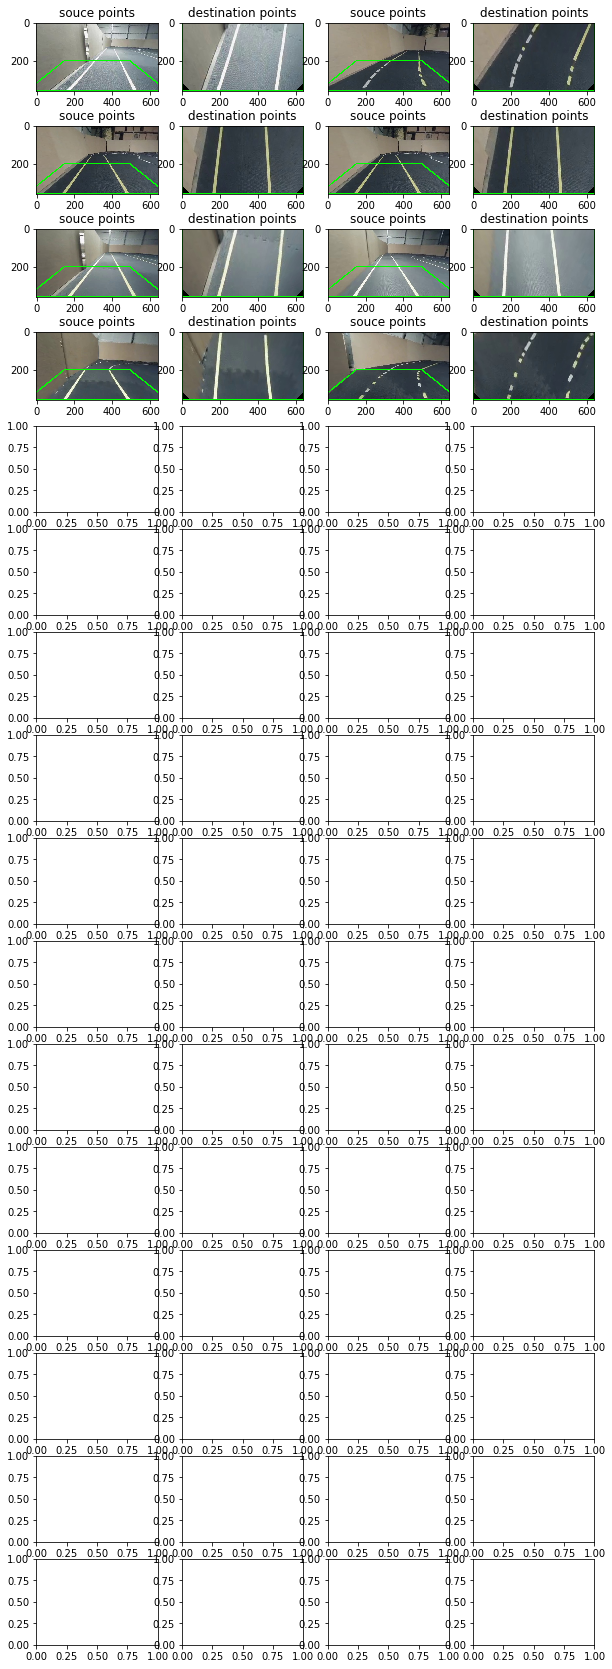

In [5]:
# Defining my destination points
# These destination points work with 'rc_test_images/00330002.jpg'
"""
dest_bottom_left = [100,340]
dest_top_left = [100,100]
dest_top_right = [500,100]
dest_bottom_right = [500,340]
dest_points = np.float32([dest_bottom_left,dest_top_left,dest_top_right,
                          dest_bottom_right])



bottom = 480
top = 100
left = 100
right = 550

# Destination Points fo 480p for original bad lighting videos
bottom = 480
top = 0
left = 25
right = 615


# Destination Points for 720p in hershel's garage with one light
bottom = 510
top = 0
left = 0
right = 640

dest_bottom_left = [left,bottom]
dest_top_left = [left,top]
dest_top_right = [right,top]
dest_bottom_right = [right,bottom]
dest_points = np.float32([dest_bottom_left,dest_top_left,dest_top_right,
                          dest_bottom_right])
                          
# Destination points fo 360x640 using fisheye
bottom = 740
top = 0
left = 0
right = 1280
"""

bottom = 360
top = 0
left = 0
right = 640
dest_bottom_left = [left,bottom]
dest_top_left = [left,top]
dest_top_right = [right,top]
dest_bottom_right = [right,bottom]
dest_points = np.float32([dest_bottom_left,dest_top_left,dest_top_right,
                          dest_bottom_right])

image_copy = np.copy(image)
M = cv2.getPerspectiveTransform(source_points,dest_points)
Minv = cv2.getPerspectiveTransform(dest_points,source_points)
img_size = (image.shape[1],image.shape[0])
birds_eye_image = cv2.warpPerspective(image_copy, M, img_size,
                                      flags=cv2.INTER_LINEAR)
dest_viewing_window = make_viewing_window(dest_bottom_left,dest_top_left,dest_top_right,dest_bottom_right)

src_image_copy = draw_viewing_window(image,src_viewing_window)
dest_image_copy = draw_viewing_window(birds_eye_image,dest_viewing_window)


f,axs = plt.subplots(16,4,figsize=(10,30))
axs = axs.ravel()
for i,img in enumerate(image_paths):
    #img = 'rc_test_images/lane' + str(i+1) + '.jpg'
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # don't forget to undistort image
    image = cv2.undistort(image,mtx,dist,None,mtx)
    image_copy = np.copy(image)
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    img_size = (image.shape[1],image.shape[0])
    birds_eye_image = cv2.warpPerspective(image_copy, M, img_size,
                                          flags=cv2.INTER_LINEAR)
    dest_viewing_window = make_viewing_window(dest_bottom_left,dest_top_left,dest_top_right,dest_bottom_right)

    src_image_copy = draw_viewing_window(image,src_viewing_window)
    dest_image_copy = draw_viewing_window(birds_eye_image,dest_viewing_window)
    
    axs[i*2].imshow(src_image_copy)
    axs[i*2].set_title('souce points')
    axs[i*2+1].imshow(dest_image_copy)
    axs[i*2+1].set_title('destination points')

## Apply birdseye view and color and gradient thresholding

i:  0
i:  1
i:  2
i:  3
i:  4
i:  5
i:  6
i:  7


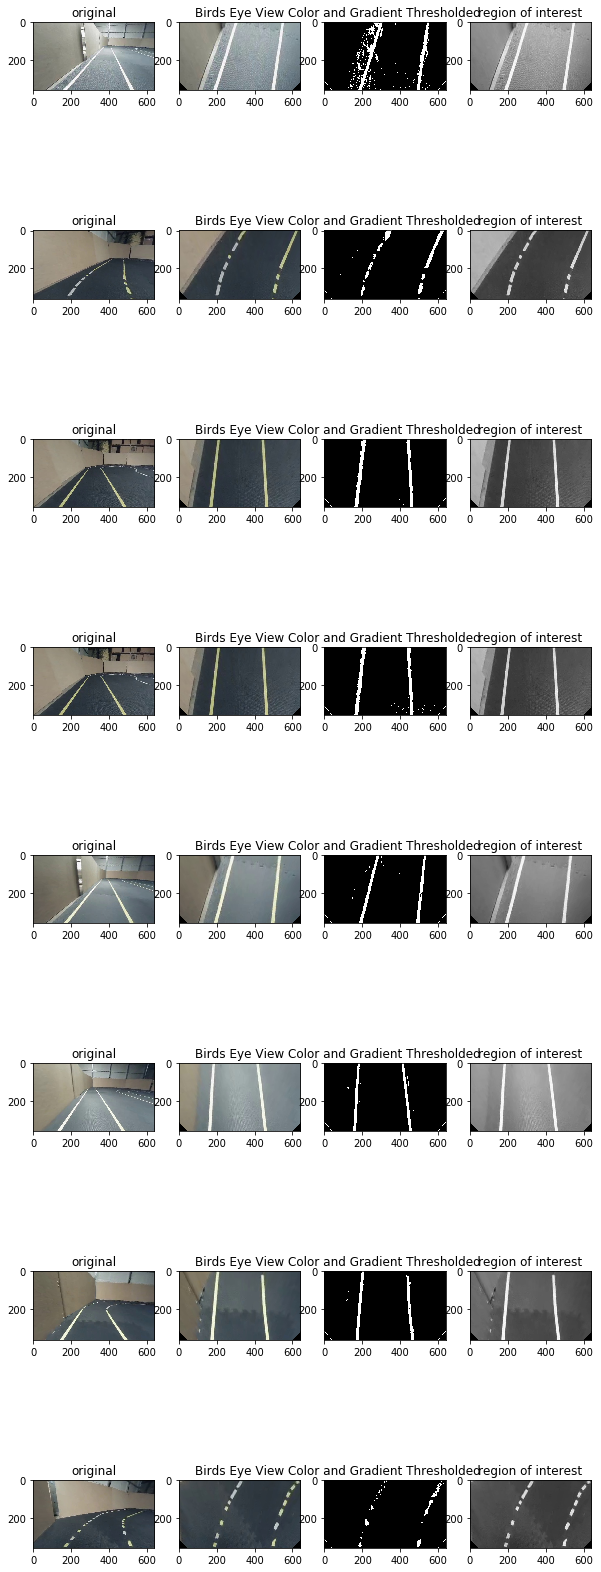

In [6]:
count = 0
f,axs = plt.subplots(num_pictures,4,figsize=(10,30))
axs = axs.ravel()
for i,img in enumerate(image_paths):
    print('i: ',i)
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # don't forget to undistort image
    
    image = cv2.undistort(image,mtx,dist,None,mtx)

    source_points = np.asarray(source_points)
    dest_points = np.asarray(dest_points)
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    img_size = (image.shape[1],image.shape[0])
    birdseye_view = cv2.warpPerspective(image, M, img_size,
                                          flags=cv2.INTER_LINEAR)
    # Applying Combined Color and Gradient Thresholding to Birds Eye View Image
    combined = combined_threshold(birdseye_view, kernel_size=3, gradx_low_thresh=30, gradx_high_thresh=255, 
                                  grady_low_thresh=40, grady_high_thresh=255, mag_low_thresh=30,
                                  mag_high_thresh=254, dir_low_thresh=0.7, dir_high_thresh=1.3,
                                  white_L_low_thresh=117, white_L_high_thresh=190, white_S_low_thresh=12, 
                                  white_S_high_thresh=255,yellow_S_low_thresh=30, yellow_S_high_thresh=140,
                                  yellow_H_low_thresh=28, yellow_H_high_thresh=53, L_agr=225)
    limit_look_ahead = 0.0
    combined = np.logical_and(combined,region_of_interest(combined,limit_look_ahead=limit_look_ahead)).astype(np.uint8)
    """
    # Original thresholding
    combined_threshold(image, kernel_size=3, gradx_low_thresh=40, gradx_high_thresh=100, 
                       grady_low_thresh=40, grady_high_thresh=100, mag_low_thresh=40,
                       mag_high_thresh=100, dir_low_thresh=0.7, dir_high_thresh=1.3,
                       S_low_thresh=140, S_high_thresh=255, L_low_thresh=40, L_high_thresh=255,
                       L_agr=205)
    """
    
    gray = cv2.cvtColor(birdseye_view, cv2.COLOR_RGB2GRAY)
    gray = region_of_interest(gray,limit_look_ahead=limit_look_ahead)
    
    #combined = apply_birdseye(image,source_points,dest_points)
    axs[i*4].imshow(image)
    axs[i*4].set_title('original')
    axs[i*4+1].imshow(birdseye_view)
    axs[i*4+1].set_title('Birds Eye View')
    axs[i*4+2].imshow(combined,cmap='gray')
    axs[i*4+2].set_title('Color and Gradient Thresholded')
    axs[i*4+3].imshow(gray,cmap='gray')
    axs[i*4+3].set_title('region of interest')
    
plt.show()


## Put Everything into one function

c:\users\adam\documents\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\adam\documents\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 0:  0.2587299346923828
process_time 1:  0.17761921882629395


c:\users\adam\documents\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 2:  0.3258016109466553


c:\users\adam\documents\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 3:  0.2885127067565918


c:\users\adam\documents\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 4:  0.25612640380859375


c:\users\adam\documents\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 5:  0.31206440925598145


c:\users\adam\documents\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\adam\documents\miniconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


process_time 6:  0.25808262825012207
process_time 7:  0.18351030349731445


"\nf, axs = plt.subplots(num_pictures,5,figsize=(10,30))\naxs = axs.ravel()\n\nfor i,image_path in enumerate(image_paths):\n    image = mpimg.imread(image_path)\n    result,image_undistorted,best_fit,windows,left_fitx,right_fitx,ploty,binary_warped = process_image(image)\n    #ploty = [i for i in ploty if i <= 480*2.5]\n    #length = len(ploty)\n    #lift_fitx = left_fitx[:length]\n    #right_fitx = right_fitx[:length]\n    axs[i*5].imshow(image_undistorted)\n    axs[i*5+1].imshow(binary_warped)\n    axs[i*5+2].imshow(windows)\n    axs[i*5+3].imshow(best_fit)\n    axs[i*5+3].plot(left_fitx,ploty,color='yellow')\n    axs[i*5+3].plot(right_fitx,ploty,color='orange')\n    axs[i*5+4].imshow(result)\n"

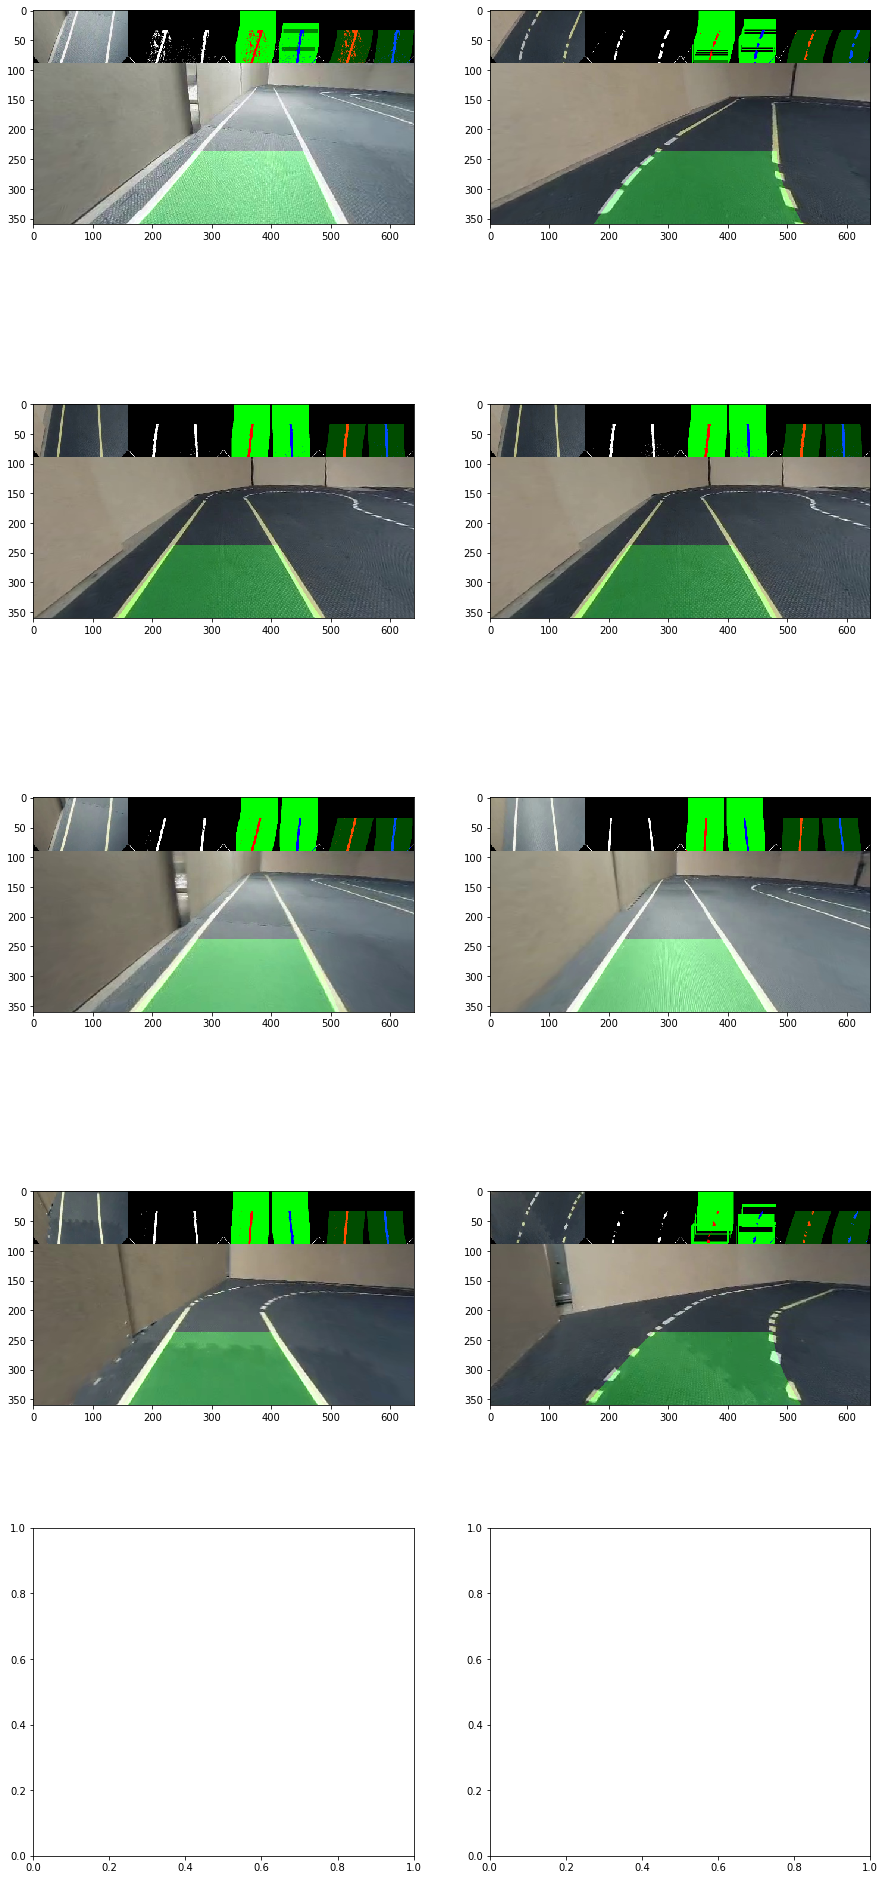

In [12]:
import time
import random
def process_image(image):
    # source points for 360x640 using fisheye in hershel's garage
    src_bottom_left = [-50,360]
    src_top_left = [150,200]
    src_top_right = [490,200]
    src_bottom_right = [690,360]
    source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                     src_bottom_right])

    bottom = 360
    top = 0
    left = 0
    right = 640
    dest_bottom_left = [left,bottom]
    dest_top_left = [left,top]
    dest_top_right = [right,top]
    dest_bottom_right = [right,bottom]
    dest_points = np.float32([dest_bottom_left,dest_top_left,dest_top_right,
                              dest_bottom_right])

    
    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    # undistort image
    image = cv2.undistort(image, mtx, dist, None, mtx)
    image_undistorted = image
    birdseye_view = apply_birdseye(image,source_points,dest_points)
    # Applying Combined Color and Gradient Thresholding to Birds Eye View Image
    combined = combined_threshold(birdseye_view, kernel_size=3, gradx_low_thresh=30, gradx_high_thresh=255, 
                                  grady_low_thresh=40, grady_high_thresh=255, mag_low_thresh=30,
                                  mag_high_thresh=254, dir_low_thresh=0.7, dir_high_thresh=1.3,
                                  white_L_low_thresh=117, white_L_high_thresh=190, white_S_low_thresh=12, 
                                  white_S_high_thresh=255,yellow_S_low_thresh=30, yellow_S_high_thresh=140,
                                  yellow_H_low_thresh=28, yellow_H_high_thresh=53, L_agr=225)
    limit_look_ahead = 0.4 # increase number to limit look ahead (1.0 is maximum; 0.0 is minimum)
    combined = np.logical_and(combined,region_of_interest(combined,limit_look_ahead=limit_look_ahead)).astype(np.uint8)

    binary_warped = combined
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/1.35):,:], axis=0) # 1.25
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 3
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    lefty_current = image.shape[0] - window_height//2
    righty_current = image.shape[0] - window_height//2
    
    # Set the width of the windows +/- margin
    #margin = 80
    margin = 120 # best is 120
    window_height = image.shape[0]//nwindows
    
  
    
    
    # Set minimum number of pixels found to recenter window
    minpix = 500 # best is 50 (500)
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Re-center window based on both x and y position
    
    # Step through the windows one by one
    #for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #win_y_low = binary_warped.shape[0] - (window+1)*window_height
        #win_y_high = binary_warped.shape[0] - window*window_height
        

    window = 0
    # Initialize top, bottom, left, and right boundaries of left and right search windows
    win_yleft_low = lefty_current + window_height//2
    win_yleft_high = lefty_current - window_height//2
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_yright_low = righty_current + window_height//2
    win_yright_high = righty_current - window_height//2
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Initialize the direction the left and right window searches move in
    left_dx = 0
    left_dy = -1
    right_dx = 0
    right_dy = -1
    
    # margin of wiggle room before stopping window search when it exits the side of the image
    side_margin = 0.0 #1.25
    # margin of wiggle room before stopping window search when it crosses into other half of image
    middle_margin = 10.0
    
    n_left_windows = 0 # Initialize the number of left windows used
    n_right_windows = 0 # Initialize the number of right windows used
    min_n_windows = 100 # min number of windows before terminating window search
    # While
    # (((left window search is within left side of image) OR (left window count is less than min_n_windows))
    # OR 
    # ((right window search is within right side of image) OR (right window count is less than min_n_windows)))
    while ((((win_xleft_low >= -1*(margin//2)*side_margin) & (win_xleft_high <= (image.shape[1]//2 + ((margin//2)*middle_margin))) & (win_yleft_high > 0)) | (n_left_windows < min_n_windows)) | \
            (((win_xright_low >= (image.shape[1]//2 - ((margin//2)*middle_margin))) & (win_xright_high <= (image.shape[1] + (margin//2)*side_margin)) & (win_yright_high > 0)) | (n_right_windows < min_n_windows))):
        #window += 1
        # Do left lane line
        # Find left, right, top, bottom, boundaries of window
        win_yleft_low = lefty_current + window_height//2
        win_yleft_high = lefty_current - window_height//2
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        #print('window number: ',window)
        # Stop performing left window search if left lane line exits left side of image
        if (((win_xleft_low >= -1*(margin//2)*side_margin) & (win_xleft_high <= image.shape[1]//2 + (margin//2)*middle_margin)) | (n_left_windows < min_n_windows)): # 1.5
            n_left_windows += 1
            # Draw window
            cv2.rectangle(out_img,(win_xleft_low,win_yleft_low),(win_xleft_high,win_yleft_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_left_inds = ((nonzeroy < win_yleft_low) & (nonzeroy >= win_yleft_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indicies to list of left lane line indicies
            left_lane_inds.append(good_left_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                #print('found minpix')
                # Always re-center x position; let new x position go to the left or right
                leftx_previous = leftx_current
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                left_dx = leftx_current - leftx_previous
                # Only re-center y position if the new center is higher up on the image than the previous center
                # higher up on the image means a smaller y value
                # 0 y value is at the top of the image
                if (np.int(np.mean(nonzeroy[good_left_inds])) < lefty_current):
                    lefty_previous = lefty_current 
                    lefty_current = np.int(np.mean(nonzeroy[good_left_inds]))
                    left_dy = lefty_current - lefty_previous
                # If the re-centering of the y position causes the window to stay in the same spot or go back down
                # then force the window to move one pixel up the image (y value goes down)
                # This way the window search does not get stuck
                # But it still moves up slowly enough that it does not miss
                # lane lines that are far apart horizontally
                else:
                    lefty_current += left_dy
            else:
                #print('didnt find minpix')
                leftx_current += left_dx
                lefty_current += left_dy
            
        
        # Do right lane line
        # Find left and right boundaries of window
        win_yright_low = righty_current + window_height//2
        win_yright_high = righty_current - window_height//2
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        area = (win_yright_low-win_yright_high)*(win_xright_high-win_xright_low)
        #print('window area: ',area)
        # Stop performing right window search if right lane line exits right side of image
        if (((win_xright_high <= image.shape[1] + (margin//2)*side_margin) & (win_xright_low >=(image.shape[1]//2 - (margin//2)*middle_margin)) | (n_right_windows < min_n_windows))): # 1.5
            n_right_windows += 1
            # Draw Window
            cv2.rectangle(out_img,(win_xright_low,win_yright_low),(win_xright_high,win_yright_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_right_inds = ((nonzeroy < win_yright_low) & (nonzeroy >= win_yright_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indicies to list of right lane line indicies
            right_lane_inds.append(good_right_inds)
            # if you found > minpix pixels, recenter next window on mean x-position
            #print('len(good_right_inds): ',len(good_right_inds))
            if len(good_right_inds) > minpix: 
                rightx_previous = rightx_current
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                right_dx = rightx_current - rightx_previous
                if (np.int(np.mean(nonzeroy[good_right_inds])) < righty_current):
                    righty_previous = righty_current
                    righty_current = np.int(np.mean(nonzeroy[good_right_inds]))
                    right_dy = righty_current - righty_previous
                else:
                    #righty_current -= 1
                    righty_current += right_dy
            else:
                #righty_current -= 1
                rightx_current += right_dx
                righty_current += right_dy

    """
    # Re-center window based on x position only
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height


        
        # Do left lane line
        # Find left and right boundaries of window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        # Stop performing window search if left lane line exits left side of image
        if (win_xleft_low >= -1*(margin//2)*2): # 1.5
            # Draw window
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            # Append these indicies to list of left lane line indicies
            left_lane_inds.append(good_left_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        
        # Do right lane line
        # Find left and right boundaries of window
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Stop performing window search if right lane line exits right side of image
        if (win_xright_high <= image.shape[1] + (margin//2)*2): # 1.5
            # Draw Window
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Get indicies of nonzero pixels within window
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indicies to list of right lane line indicies
            right_lane_inds.append(good_right_inds)
            # if you found > minpix pixels, recenter next window on mean x-position
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    """
    
    # Concatenate the arrays of indices
    if (len(left_lane_inds) > 0):
        left_lane_inds = np.concatenate(left_lane_inds)
    if (len(right_lane_inds) > 0):
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    left_lane_inds = np.unique(left_lane_inds) # get rid of repeats
    right_lane_inds = np.unique(right_lane_inds) # get rid of repeats
    #print('right_lane_inds: ',right_lane_inds)
    
    # Temporary fix
    if (len(left_lane_inds) > 0):
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
    else:
        leftx = []
        lefty = []
    if (len(right_lane_inds) > 0):
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
    else:
        rightx = []
        righty = []
        
    ploty = np.linspace(limit_look_ahead*image.shape[0], (binary_warped.shape[0]-1)*1.25, binary_warped.shape[0] )
    left_fit = [0,0,0]
    right_fit = [0,0,640]
    n = 2 # degree of polynomial for best-fit line (2 works best)
    
    # Fit a second order polynomial to each
    # Temporary fix
    if ((len(lefty) > 0) & (len(leftx) > 0)):
        #left_fit = np.polyfit(lefty, leftx, 2)
        
        left_model = make_pipeline(PolynomialFeatures(n), RANSACRegressor(random_state=42))
        left_model.fit(lefty.reshape(-1,1), leftx)

        # getting coefficients of best-fit curve
        # for some reason the one line of code below fails to return the correct coefficients
        # it only returns 2/3 of the coefficients
        # one coefficient is always zero...
        # so I have to re-calculate the coefficients using np.polyfit()
        # we need the coefficients of the best-fit line to calculate radius of curvature
        #left_fit = left_model.named_steps['ransacregressor'].estimator_.coef_
        
        left_fitx = left_model.predict(ploty.reshape(-1,1))
        left_fit = np.polyfit(ploty,left_fitx,2)
        
    
        
    else:
        left_fit = [0,0,0]
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        
    if ((len(righty) > 0) & (len(rightx) > 0)):
        #right_fit = np.polyfit(righty, rightx, 2)
        
        right_model = make_pipeline(PolynomialFeatures(n), RANSACRegressor(random_state=42))
        right_model.fit(righty.reshape(-1,1), rightx)
        
        # getting coefficients of best-fit curve
        # for some reason the one line of code below fails to return the correct coefficients
        # it only returns 2/3 of the coefficients
        # one coefficient is always zero...
        # so I have to re-calculate the coefficients using np.polyfit()
        # we need the coefficients of the best-fit line to calculate radius of curvature
        #right_fit = right_model.named_steps['ransacregressor'].estimator_.coef_
        
        right_fitx = right_model.predict(ploty.reshape(-1,1))
        right_fit = np.polyfit(ploty,right_fitx,2)
        
        
    else:
        right_fit = [0,0,640]
        #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate x and y values for plotting
    #ploty = np.linspace(limit_look_ahead*image.shape[0], (binary_warped.shape[0]-1)*1.25, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    

    # Temporary fix
    if (len(left_lane_inds) > 0):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    if (len(right_lane_inds) > 0):
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    windows = out_img

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    # Temporary fix
    if (len(left_lane_inds) > 0):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    if (len(right_lane_inds) > 0):
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    best_fit = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Calculating radius of curvature at bottom of picture in pixels
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    yinches_per_pix = 8/480
    xinches_per_pix = 5/640

    # Fit new polynomials to x,y in world space
    #print('length of ploty: ',len(ploty))
    #print('length of leftx: ',len(leftx))
    #print('length of rightx: ',len(rightx))
    if (((len(lefty) != 0) & (len(leftx) != 0))):
        left_fit_cr = np.polyfit(lefty*yinches_per_pix, leftx*xinches_per_pix, 2)
    else:
        left_fit_cr = [0,0,0]
    if (((len(righty) != 0) & (len(rightx) != 0))):
        right_fit_cr = np.polyfit(righty*yinches_per_pix, rightx*xinches_per_pix, 2)
    else:
        right_fit_cr = [0,0,1280*xinches_per_pix]
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*yinches_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*yinches_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    warped = binary_warped
    height = warped.shape[0]
    width = warped.shape[1]

    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    warp_zero = np.zeros((int(height*1.25),width),np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    height = image.shape[0]
    width = image.shape[1]
    vehicle_center = width/2
    left_lane_position = (left_fit[0] * (height**2)) + (left_fit[1] * height) + left_fit[2]
    right_lane_position = (right_fit[0] * (height**2)) + (right_fit[1] * height) + right_fit[2]
    actual_center = left_lane_position + (right_lane_position - left_lane_position) / 2
    vehicle_position = (actual_center - vehicle_center) * xinches_per_pix
    vehicle_position = round((vehicle_position),2)



    font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(result, "Left Radius Of Curvature: " + str(round(left_curverad,0)), (50, 50), font, 1.1, (255, 255, 255), 2, cv2.LINE_AA)
    #cv2.putText(result, "Right Radius Of Curvature: " + str(round(right_curverad,0)), (50, 100), font, 1.1, (255, 255, 255), 2, cv2.LINE_AA)
    if (vehicle_position < 0):
        vehicle_position_str = str(np.absolute(vehicle_position)) + " inches right of center"
    elif (vehicle_position > 0):
        vehicle_position_str = str(np.absolute(vehicle_position)) + " inches left of center"
    else:
        vehicle_position_str =  "on center"
    #cv2.putText(result, vehicle_position_str, (50,150), font, 1.1, (255,255,255), 2, cv2.LINE_AA)
    
    height = birdseye_view.shape[0]
    width = birdseye_view.shape[1]

    birdseye_view = resize(birdseye_view, (height//4,width//4))*255
    binary_warped = resize(binary_warped, (height//4,width//4))*255
    windows = resize(windows, (height//4,width//4))*255
    best_fit = resize(best_fit, (height//4,width//4))*255


    binary_warped_color = np.zeros_like(windows)
    binary_warped_color[:,:,0] = binary_warped*255
    binary_warped_color[:,:,1] = binary_warped*255
    binary_warped_color[:,:,2] = binary_warped*255
    
    """
    offset = [0, 320, 640, 960]
    width, height = 320,180

    result[:height, offset[0]: offset[0] + width] = birdseye_view
    result[:height, offset[1]: offset[1] + width] = binary_warped_color
    result[:height, offset[2]: offset[2] + width] = windows
    result[:height, offset[3]: offset[3] + width] = best_fit
    """
    
    offset = [0 ,160, 320, 480]
    width, height = 160,90
    #print('result.shape: ',result.shape)
    result[:height, offset[0]: offset[0] + width] = birdseye_view
    result[:height, offset[1]: offset[1] + width] = binary_warped_color
    result[:height, offset[2]: offset[2] + width] = windows
    result[:height, offset[3]: offset[3] + width] = best_fit

    #return result,image_undistorted,best_fit,windows,left_fitx,right_fitx,ploty,binary_warped,birdseye_view
    return result



# Display all relevant images on one image for debugging
f,axs = plt.subplots(num_pictures//2+1,2,figsize=(15, 35))
axs = axs.ravel()

for i,image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    t1 = time.time()
    result = process_image(image)
    t2 = time.time()
    process_time = t2-t1
    print('process_time %d: ' % i,process_time)

    
    axs[i].imshow(result)




# Display all relevant images as separate images
"""
f, axs = plt.subplots(num_pictures,5,figsize=(10,30))
axs = axs.ravel()

for i,image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)
    result,image_undistorted,best_fit,windows,left_fitx,right_fitx,ploty,binary_warped = process_image(image)
    #ploty = [i for i in ploty if i <= 480*2.5]
    #length = len(ploty)
    #lift_fitx = left_fitx[:length]
    #right_fitx = right_fitx[:length]
    axs[i*5].imshow(image_undistorted)
    axs[i*5+1].imshow(binary_warped)
    axs[i*5+2].imshow(windows)
    axs[i*5+3].imshow(best_fit)
    axs[i*5+3].plot(left_fitx,ploty,color='yellow')
    axs[i*5+3].plot(right_fitx,ploty,color='orange')
    axs[i*5+4].imshow(result)
"""


## IGNORE code below this block

## Alternative winow search based on performing convolutions

In [ ]:
# Window_mask is a function to draw window areas
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    left_window_centroids = [] # list to store left lane line window centroid positions per level
    right_window_centroids = [] # list to store right lane line window centroid positions per level
    
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Only perform left window search within left-hand side of image
        #print('level: ',level)
        if ((l_center >= 25) & (l_center <= image.shape[1]//2)):
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            #print('l_min_index: ',l_min_index)
            #print('l_max_index: ',l_max_index)
            #print('l_center: ',l_center)
            left_window_centroids.append(l_center)
        #print('r_center: ',r_center)
        # Only perform right window search within right-hand side of image
        if ((r_center <= image.shape[1]) & (r_center >= image.shape[1]//2)):
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            #print('r_min_index: ',r_min_index)
            #print('r_max_index: ',r_max_index)
            #print('r_center: ',r_center)
            #print()
            right_window_centroids.append(r_center)
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return left_window_centroids,right_window_centroids

def process_image(image):
    # source points for 720p using one light in hershel's garage
    src_bottom_left = [-50,720]
    src_top_left = [300,450]
    src_top_right = [980,450]
    src_bottom_right = [1330,720]
    source_points = np.float32([src_bottom_left,src_top_left,src_top_right,
                     src_bottom_right])

    bottom = 740
    top = 0
    left = 0
    right = 1280

    dest_bottom_left = [left,bottom]
    dest_top_left = [left,top]
    dest_top_right = [right,top]
    dest_bottom_right = [right,bottom]
    dest_points = np.float32([dest_bottom_left,dest_top_left,dest_top_right,
                              dest_bottom_right])


    M = cv2.getPerspectiveTransform(source_points,dest_points)
    Minv = cv2.getPerspectiveTransform(dest_points,source_points)
    # undistort image
    image = cv2.undistort(image, mtx, dist, None, mtx)
    image_undistorted = image
    birdseye_view = apply_birdseye(image,source_points,dest_points)
    combined = combined_threshold(birdseye_view, kernel_size=3, gradx_low_thresh=40, gradx_high_thresh=255, 
                                  grady_low_thresh=40, grady_high_thresh=255, mag_low_thresh=60,
                                  mag_high_thresh=254, dir_low_thresh=0.7, dir_high_thresh=1.3,
                                  white_L_low_thresh=100, white_L_high_thresh=205, white_S_low_thresh=57, 
                                  white_S_high_thresh=200, yellow_S_low_thresh=50, yellow_S_high_thresh=255,
                                  yellow_H_low_thresh=20, yellow_H_high_thresh=30, L_agr=205)
    limit_look_ahead = 0.0
    combined = np.logical_and(combined,region_of_interest(combined,limit_look_ahead=limit_look_ahead)).astype(np.uint8)

    warped = combined
    
    # window settings
    n_windows = 10
    window_width = 100 # Initially 50
    window_height = warped.shape[0]//n_windows # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching (intially 100)
    
    left_window_centroids,right_window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if ((len(left_window_centroids) > 0) | (len(right_window_centroids) > 0)):

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        """
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        """

        # Visualize window search

        # Go through each level and draw the windows for right lane line
        for level in range(0,len(right_window_centroids)):
            r_mask = window_mask(window_width,window_height,warped,right_window_centroids[level],level)
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Go through each level and draw the windows for left lane line
        for level in range(0,len(left_window_centroids)):
            l_mask = window_mask(window_width,window_height,warped,left_window_centroids[level],level)
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255

        # Draw the results

        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        windows = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # Generate y values for plotting best-fit curves
        ploty = np.linspace(limit_look_ahead*image.shape[0], (image.shape[0]-1)*1.25, image.shape[0] )

        # Do right lane line

        # Create blank image
        warped_right_lane_line = np.zeros_like(warped)
        # Color right lane line pixels white
        warped_right_lane_line[(warped == 1) & (r_points == 255)] = 255
        # Get right lane line pixels indicies
        right_lane_line_inds = warped_right_lane_line.nonzero()
        # Get x positions of right lane line pixels
        rightx = right_lane_line_inds[1]
        # Get y positions of right lane line pixels
        righty = right_lane_line_inds[0]
        # Get best-fit line coefficients for right lane line 
        right_fit = np.polyfit(righty,rightx,2)
        # Generate predicted x values for plotting predicted right lane line
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Re-create image into 3 channel image with right lane line pixels colored blue
        zero_channel = np.zeros_like(warped)
        warped_right_lane_line = np.array(cv2.merge((zero_channel,zero_channel,warped_right_lane_line)),np.uint8)

        # Do left lane line

        # Create blank image
        warped_left_lane_line = np.zeros_like(warped)
        # Color left lane line pixels white
        warped_left_lane_line[(warped == 1) & (l_points == 255)] = 255
        # Get left lane line pixels indicies
        left_lane_line_inds = warped_left_lane_line.nonzero()
        # Get x positions of left lane line pixels
        leftx = left_lane_line_inds[1]
        # Get y positions of left lane line pixels
        lefty = left_lane_line_inds[0]
        # Get best-fit line coefficients for left lane line
        left_fit = np.polyfit(lefty,leftx,2)
        # Generate predicted x values for plotting predicted left lane line
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        # Re-create image into 3 channel image with left lane line pixels colored red
        zero_channel = np.zeros_like(warped)
        warped_left_lane_line = np.array(cv2.merge((warped_left_lane_line,zero_channel,zero_channel)),np.uint8)

        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        # Black out parts of original warped image where the lane lines are colored in
        warpage[lefty,leftx] = 0
        warpage[righty,rightx] = 0
        # Add all three images together to see how well lane line detection is coloring in lane lines
        red_and_blue_lane_lines = np.array(warped_right_lane_line+warped_left_lane_line+warpage,np.uint8)

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((warped, warped, warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))


        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        best_fit = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        height = warped.shape[0]
        width = warped.shape[1]

        # Create an image to draw the lines on
        #warp_zero = np.zeros_like(warped).astype(np.uint8)
        warp_zero = np.zeros((int(height*1.25),width),np.uint8)

        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        binary_warped = warped
        
        birdseye_view = imresize(birdseye_view, 0.25)
        binary_warped = imresize(binary_warped, 0.25)
        windows = imresize(windows, 0.25)
        best_fit = imresize(best_fit, 0.25)


        binary_warped_color = np.zeros_like(windows)
        binary_warped_color[:,:,0] = binary_warped*255
        binary_warped_color[:,:,1] = binary_warped*255
        binary_warped_color[:,:,2] = binary_warped*255

        offset = [0, 320, 640, 960]
        width, height = 320,180

        result[:height, offset[0]: offset[0] + width] = birdseye_view
        result[:height, offset[1]: offset[1] + width] = binary_warped_color
        result[:height, offset[2]: offset[2] + width] = windows
        result[:height, offset[3]: offset[3] + width] = best_fit


    # If no window centers found, just display orginal road image
    else:
        result = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        
    #return result,image_undistorted,best_fit,windows,left_fitx,right_fitx,ploty,binary_warped,birdseye_view
    return result


# Display all relevant images on one image for debugging
f,axs = plt.subplots(num_pictures,1,figsize=(25,45))
axs = axs.ravel()
for i,image_path in enumerate(image_paths):
    image = mpimg.imread(image_paths[i])
    result = process_image(image)

    axs[i].imshow(result)

    
plt.show()

"""
f,axs = plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(result)
axs[1].imshow(warped)
axs[2].imshow(windows)
#axs[2].plot(right_fitx,ploty,color='blue')
#axs[2].plot(left_fitx,ploty,color='red')
axs[3].imshow(best_fit)
#plt.imshow(warped_right_lane_line)
#plt.plot(right_fitx,ploty,color='blue')
#print(ploty)
#plt.title('window fitting results')
plt.show()
"""
